### sample_data, files.zip

In [1]:
!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zpOLZ-iJLSUvjaemYoI7hE_CdsW0rKEC' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1zpOLZ-iJLSUvjaemYoI7hE_CdsW0rKEC" -O files.zip && rm -rf ~/cookies.txt

--2022-03-12 18:51:22--  https://docs.google.com/uc?export=download&confirm=t&id=1zpOLZ-iJLSUvjaemYoI7hE_CdsW0rKEC
Resolving docs.google.com (docs.google.com)... 74.125.195.101, 74.125.195.138, 74.125.195.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-3g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ovhci4j33oe6pdm6784vl1ou76erhh9n/1647111075000/09977954582062536659/*/1zpOLZ-iJLSUvjaemYoI7hE_CdsW0rKEC?e=download [following]
--2022-03-12 18:51:22--  https://doc-10-3g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ovhci4j33oe6pdm6784vl1ou76erhh9n/1647111075000/09977954582062536659/*/1zpOLZ-iJLSUvjaemYoI7hE_CdsW0rKEC?e=download
Resolving doc-10-3g-docs.googleusercontent.com (doc-10-3g-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-10-3g-docs.googleusercontent.com (doc-10-3g

### data, model.pth

In [2]:
!unzip files.zip

Archive:  files.zip
  inflating: data/mask3.jpg          
  inflating: data/normal.jpg         
  inflating: data/mask5.jpg          
  inflating: data/incorrect_mask.jpg  
  inflating: data/mask2.jpg          
  inflating: data/mask4.jpg          
  inflating: data/mask1.jpg          
  inflating: model.pth               


# VGG-11 semantic segmentation
- last fc layer to 1x1 conv layer
- to preserve spatial information
- fc layer and 1x1 conv layer have the same number of weights
- reshaping weights from fc layer to weight of 1x1 layer to make VGG-11 become a segmentation model
- such a model is called FCN (Fully Convolutional Network)

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import os
import cv2
import numpy as np
from glob import glob
from matplotlib import pyplot as plt

In [4]:
class VGG11Backbone(nn.Module):

    def __init__(self):
        super(VGG11Backbone, self).__init__()

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3_1   = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3_2   = nn.BatchNorm2d(256)
        self.pool3   = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4_1   = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4_2   = nn.BatchNorm2d(512)
        self.pool4   = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_1   = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_2   = nn.BatchNorm2d(512)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = self.conv3_1(x)
        x = self.bn3_1(x)
        x = self.relu(x)
        x = self.conv3_2(x)
        x = self.bn3_2(x)
        x = self.relu(x)
        x = self.pool3(x)

        x = self.conv4_1(x)
        x = self.bn4_1(x)
        x = self.relu(x)
        x = self.conv4_2(x)
        x = self.bn4_2(x)
        x = self.relu(x)
        x = self.pool4(x)

        x = self.conv5_1(x)
        x = self.bn5_1(x)
        x = self.relu(x)
        x = self.conv5_2(x)
        x = self.bn5_2(x)
        x = self.relu(x)

        return x   

In [5]:
class VGG11Classification(nn.Module):

    def __init__(self, num_classes=7):
        super(VGG11Classification, self).__init__()

        self.backbone = VGG11Backbone()
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc_out = nn.Linear(512, num_classes)

    def forward(self, x):

        x = self.backbone(x)
        x = self.pool5(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.fc_out(x)

        return x

In [6]:
class VGG11Segmentation(nn.Module):

    def __init__(self, num_classes=7):
        super(VGG11Segmentation, self).__init__()

        # backbone
        self.backbone = VGG11Backbone()

        # gradient calculation disabled
        with torch.no_grad():
            # 1x1 conv layer
            self.conv_out = nn.Conv2d(512, num_classes, kernel_size=1, padding=0, stride=1)

        # upsampling
        self.upsample = nn.Upsample(scale_factor=16, mode='bilinear', align_corners=False)
    
    def forward(self, x):

        x = self.backbone(x)
        x = self.conv_out(x)
        x = self.upsample(x)

        assert x.shape==(1, 7, 224, 224)

        return x

    def copy_last_layer(self, fc_out):
        # input: fc_out
        # output: conv_out
        # weights of fc_out get converted into weights of conv_out

        reshaped_fc_out = fc_out.weight.detach() # detach: returns tensor (shared storage) detached from computational graph
        reshaped_fc_out = torch.reshape(reshaped_fc_out, (7, 512, 1, 1))
        
        self.conv_out.weight = nn.Parameter(reshaped_fc_out)

        assert self.conv_out.weight[0][0] == fc_out.weight[0][0]

        return

In [7]:
modelC = VGG11Classification()
modelC.fc_out.weight.shape # last fc layer

torch.Size([7, 512])

In [8]:
modelS = VGG11Segmentation()
modelS.conv_out.weight.shape # last 1x1 conv layer

torch.Size([7, 512, 1, 1])

In [9]:
test_input = torch.randn((1, 3, 224, 224))

c_out = modelC(test_input)
print(c_out.shape)

s_out = modelS(test_input)
print(s_out.shape)

torch.Size([1, 7])
torch.Size([1, 7, 224, 224])


### dataloader

In [10]:
class MaskDataset(Dataset):

    def __init__(self, data_root, input_size=224, transform=None):
        super(MaskDataset, self).__init__()

        self.img_list = glob(os.path.join(data_root, '*.jpg'))
        self.len = len(self.img_list)
        self.input_size = input_size
        self.transform = transform

    def __getitem__(self, index):

        img_path = self.img_list[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img/225.

        if self.transform:
            img = self.transform(img)

        label = self._get_class_idx_from_img_name(img_path)

        return img, label

    def __len__(self):

        return self.len

    def _get_class_idx_from_img_name(self, img_path):

        img_name = os.path.basename(img_path)

        if 'normal' in img_name:
            return 0
        elif 'mask1' in img_name:
            return 1
        elif 'mask2' in img_name:
            return 2
        elif 'mask3' in img_name:
            return 3
        elif 'mask4' in img_name:
            return 4
        elif 'mask5' in img_name:
            return 5
        elif 'incorrect_mask' in img_name:
            return 6
        else:
            raise ValueError(f"{img_name} is not a valid filename. Please change the name of {img_path}.")

In [11]:
os.path.join('./data', '*.jpg')

'./data/*.jpg'

In [12]:
img_list = glob(os.path.join('./data', '*.jpg'))
img_list

['./data/mask3.jpg',
 './data/mask4.jpg',
 './data/mask5.jpg',
 './data/normal.jpg',
 './data/mask2.jpg',
 './data/incorrect_mask.jpg',
 './data/mask1.jpg']

In [13]:
img_path = img_list[0]
img_path

'./data/mask3.jpg'

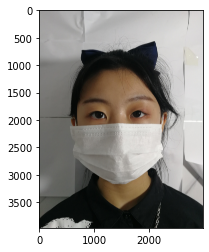

In [14]:
img = cv2.imread(img_path) 
# return type: numpy ndarray

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# cv2.imshow(img) # cv2.imshow() is disabled in Colab, because it causes Jupyter sessions
plt.imshow(img)

# Weight reshaping

In [15]:
# loading model
model_root = './model.pth'

modelC = VGG11Classification()
modelC.load_state_dict(torch.load(model_root))

<All keys matched successfully>

In [16]:
modelS = VGG11Segmentation()

# copying the backbone
modelS.backbone = modelC.backbone

# copying the weights of fc_out into conv_out
fc_out = modelC.fc_out
modelS.copy_last_layer(fc_out)

# Visualization

In [17]:
data_root = './data'
input_size = 224
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
batch_size = 1

test_dataset = MaskDataset(data_root, input_size=input_size, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


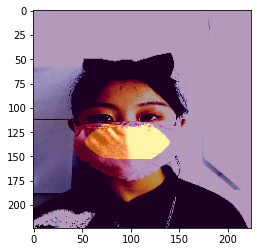

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


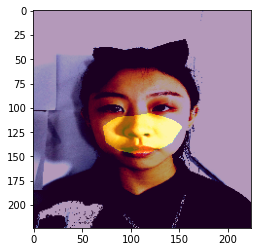

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


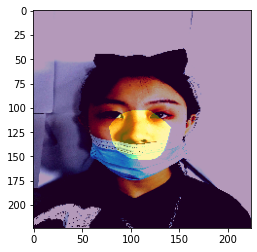

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


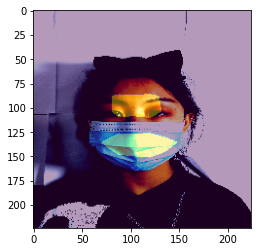

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


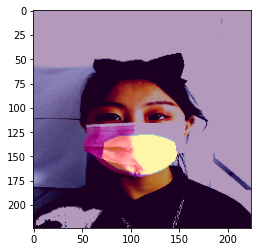

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


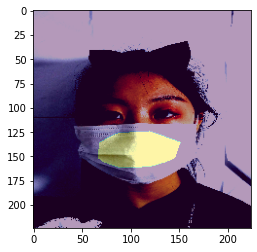

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


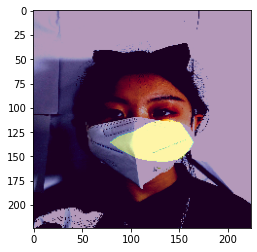

In [18]:
modelS.cuda().float()
modelS.eval()

for iter, (img, label) in enumerate(test_loader):

    img = img.float().cuda()

    res = modelS(img)[0]

    heat = res[label[0]]
    resH = heat.cpu().detach().numpy()
    heatR, heatC = np.where(resH > np.percentile(resH, 95))

    seg = torch.argmax(res, dim=0)
    seg = seg.cpu().detach().numpy()
    [segR, segC] = np.where(seg == np.int(label[0].cpu()))

    resS = np.zeros((224,224))

    for i, r in enumerate(heatR):
        c = heatC[i]
        if (r in segR) and (c in segC):
            resS[r,c] = 1

    want_to_check_heat_map_result=False

    plt.imshow(img[0].cpu().permute(1, 2, 0))
    if want_to_check_heat_map_result:
        plt.imshow(resH, cmap='jet', alpha=0.3)
    plt.imshow(resS, alpha=0.4)
    plt.show()